# Classifying high-redshift merging galaxies with deep neural networks and DeepMerge

[SLIDES FROM THIS MORNING](https://docs.google.com/presentation/d/1GUPf2pCBxNch-KI--KSnxFP8LmAiqSc0HZLOeavULQw/edit?usp=sharing) 


***

## Learning Goals


**In this tutorial, you will see an example of building, compiling, and training a CNN on simulated astronomical data.**  By the end of this tutorial you will have a working example of a simple Convolutional Neural Network (CNN) in Keras. 

## Introduction
CNNs are a class of machine learning (ML) algorithms that can extract information from images.  In this notebook, you will walk through the basic steps of applying a CNN to data:
1. Load the data and visualize a sample of the data
2. Divide the data into training, validation, and testing sets.
3. Build a CNN in Keras
4. Compile the CNN
5. Train the CNN to perform a classification task
6. Evaluate the results.

CNNs can be applied to a wide range of image recognition tasks, including classification and regression.  Here, we will build, compile, and train CNN to classify whether a galaxy has undergone a merger from simulated Hubble Space Telescope images of galaxies. This work is based on the public data and code from <a href='https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract'>DeepMerge (Ciprijanovic et al. 2020)</a>. 

**NOTE:** *The [DeepMerge team has publicly-available code](https://github.com/deepskies/deepmerge-public) for demonstrating the architecture and optimal performace of the model, which we encourage you to check out! The goal of this notebook is to step through the model building and training process.*


## Artificial Neurons - building blocks of neural networks

Neural networks learn from examples just like humas! Their building blocks are artificial neurons that are inspired by acctuall neurons in our brains (the idea was firs born in 1943. , Warren McCulloch and Walter Pitts).

![](https://historyofinformation.com/images/Screen_Shot_2020-09-09_at_6.46.46_AM_big.png)

Actual neuron:

![](https://www.jeremyjordan.me/content/images/2018/01/Neuron_Hand-tuned.png)

Artificial neuron:

![](https://www.jeremyjordan.me/content/images/2018/01/single_neuron.jpg)

## Convolutional Neural Network (CNN)  for Image Classification

CNNs are comprised from two types of layers: **2D convolutional layers** and **1D fully-connected (or dense) layers**.

In each convolutional layer we scan the images with filters that try to search out some combination of color and morphology -- like edges, wavelet patterns, etc. The next layer of the CNN then takes the previous layer's output as input, and then search for higher-level (or more complex) morphological features. For example, multiple edges at different angles can be used to detect curves, and different kinds of wavelets might be combined to identify textured patterns.

In functional form, a neural network might look something like this:

$$ {\rm CNN}(x) = {\rm Layer_{\rm final}} \Big [ \cdots \Big ( {\rm Layer_2} \big ( {\rm Layer}_1(x) \big ) \Big) \Big ], $$

where each layer might contain a convolutional layer and other ingredients (see section below).

![Credit: https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)


How do convolutions work? These are just matrix multiplications!
<!-- ![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif) -->
![](http://media5.datahacker.rs/2020/12/movie1-1-1.gif)

After enough seful features has been extracted and the dimensionality of the layer has been reduced this information is flattened into a 1D vector, and used in subsequent dense layers to learn to perform a specific task, such as image classification!

Additional imporant terms: 

**Batch normalization** - Due to memory constraints, we need to feed in images one "batch" at a time. Images flow through the network one batch at a time, so the inputs should be arrays of size  (𝑁batch size,𝑁filters,𝑁height,𝑁width) . For example a batch of 64 three-color  100×100 images has the array shape  (64,3,160,160) .

Batch normalization (batchnorm) is a mechanism that keeps the distribution of activations close to a Gaussian distribution to allow the model to train better.

**Pooling** - As we go deeper into the network the number of filter increases! To lessen the computational burden, we rely on pooling layers: often max pooling or mean pooling are commonly seen. For example, if you double the number of filters, but halve the height and width of the output image by using max pooling with a  2×2  kernel, then you still have fewer outputs than from the preceding layer!

**Activation funcitons** - they add nonlinearities to the network allowing us to combine huge number of neurons and build comlex models. The rules of linear algebra state that the product of any number of matrices can be represented by yet another matrix. If you want something that's not represented by just a single matrix, you need a non-linear function in between neural network layers. Some of the most commontly used activation functions are ReLU, Softmax, Sigmoid etc.

![](https://media.licdn.com/dms/image/C4E12AQFqIFCj71YJPw/article-cover_image-shrink_600_2000/0/1620764635917?e=2147483647&v=beta&t=E6iCHNUyncJu9QUjCX4EmVLgQanUw_WS6KnWrlV4Roc)

## Imports
This notebook uses the following packages:
- *numpy* to handle array functions
- *astropy* for downloading and accessing FITS files
- *matplotlib.pyplot* for plotting data
- *keras* and *tensorflow* for building the CNN

In [ ]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### 1. Load the data and visualize a sample of the data

Load the simulated galaxy observations (3-band images) and merger probabilities (output labels).  These data are described in detail in  <a href='https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract'>Ciprijanovic et al. 2020</a>.

In total, there are 15,426 simulated images, each in three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope, and F), retrieved and augmented from synthetic observations of the Illustris cosmological simulation. The sample includes 8120 galaxy mergers and 7306 non-mergers. Two versions of the sample are available, with and without realistic observational and experimental noise ("pristine" and "noisy"). 

These datasets are hosted at the Mikulski Archive for Space Telescopes as an HLSP. See the [DEEPMERGE](https://stdatu.stsci.edu/hlsp/deepmerge) website for more information. 

The CNN will be trained to distinguish between merging and non-merging galaxies. 


### Load the data

The simulated images are stored in FITS format. We refer you to the [Astropy Documentation](https://docs.astropy.org/en/stable/io/fits/index.html) for further information about this format. 

For this example, we will download the "pristine" set of galaxy images, i.e., those without added observational noise. To select the "noisy" sample, change the version below. Alternatively, you can download data files from the [DEEPMERGE](https://stdatu.stsci.edu/hlsp/deepmerge) website.

In [ ]:
version = 'pristine'

In [ ]:
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

Explore the header of the file for information about its contents

In [ ]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

The file includes a primary header card with overall information, an image card with the simulated images, and a bintable with the merger labels for the images (1=merger, 0=non-merger).

### Plot example images

For a random selection of images, plot the images and their corresponding labels:

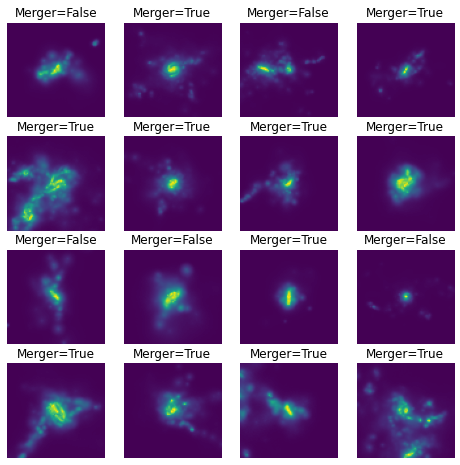

In [ ]:
# select random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0],16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j,1,:,:] for j in example_ids]

# initialize your figure
fig1=plt.figure(figsize=(8,8))

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    
    norm = simple_norm(image, 'log')

    plt.imshow(image, aspect='auto', cmap='viridis', norm=norm)
    plt.title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))
    
plt.show()

## 2. Divide data into training, validation, and testing sets

To divide the data set into training, validation, and testing data we will use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

![](https://www.brainstobytes.com/content/images/2020/01/Sets.png)

We will denote the input images as "X" and the output labels as "Y".

In [ ]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test


In [ ]:
X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=42, shuffle=True)

Next, reshape the image array as follows:  (number_of_images, image_width, image_length, 2) 
This is referred to as a "channels last" approach, where the final axis denotes the number of "colors" or "channels".  Our two-filter images have two channels, while RGB images have three.  CNN's will work with an arbitrary number of channels.

In [ ]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

### 3. Build a CNN in Keras

Here, we will build the model described in Section 3 of [Ciprijanovic et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract)

Further details about Conv2D, MaxPooling2D, BatchNormalization, Dropout, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).  Further details about the sigmoid and softmax activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [ ]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

model = Model(inputs=x_in, outputs=y_out)

### 4. Compile the CNN

Next, we compile the model.  As in [Ciprijanovic et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract), we select the Adam opmimizer and the binary cross entropy loss function (as this is a binary classification problem). 

You can learn more about [optimizers](https://keras.io/api/optimizers/) and more about [loss functions for regression tasks](https://keras.io/api/losses/) in the [Keras documentation](https://keras.io/)

In [ ]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 37, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 16)        1168  

## Loss function

During training we need to choose a function that describes how well the model is doing - we call this a loss function. The goal of the trainign proceadure is to update the weights of the model such that over time the loss function is minimized. The most common loss function for classification tasks is **cross-entropy**.
![](https://miro.medium.com/v2/resize:fit:919/1*ETtY7KCrzAlOmLeyDWE4Xg.png)

In case of 2 classes we can write it as (and call it binarry cross-entropy):
![](https://i.stack.imgur.com/HlYNr.png)

Loss landscape:

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/63d287c3b82b3b3dffedb9b5_Loss%20landscape%20during%20model%20optimization.webp)

**Gradient Descent** 

The gradient,  $\nabla_\theta J(\theta; x)$ , points in the direction (in our model parameter space) that corresponds to lower loss - finds better values of our model parameters  $\theta$ in order to improve predictions. 

The smoothness of our loss landscape matters a lot here, since the direction of steepest descent might vary wildly. This is a challenging problem for optmization, which is why it is common to use adaptive approaches, such as **Adam aptimizer** (it keeps track of previous update directions, and includes a small contribution from those prior steps in the update rule).

![](https://miro.medium.com/v2/resize:fit:1200/1*STiRp7PW5yIrvYZupZA6nw.gif)

## Learning rate


The learning rate is the most important hyperparameter for *efficiently* training a neural network. It determines how large each update is. For example, a 1-dimension loss landscape $J(\theta)$ is shown below, while gradients multiplied by the learning rate are shown as red arrows:

![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

### 5. Train the CNN to perform a classification task

We will start with training for 20 epochs, but this almost certainly won't be long enough to get great results.  Once you've run your model and evaluated the fit, you can come back here and run the next cell again for 100 epochs or longer.  

You can learn more about model.fit [here](https://keras.rstudio.com/reference/fit.html)

In [ ]:
nb_epoch = 20 #change to 5 or 10! (one epoch is around a minut!)
batch_size = 128
shuffle = True

# Train
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_valid, y_valid),                
                    shuffle=shuffle,
                    verbose=True)

Epoch 1/20
85/85 [==============================] - 69s 798ms/step - loss: 0.6975 - accuracy: 0.5271 - val_loss: 0.6930 - val_accuracy: 0.5269
Epoch 2/20
85/85 [==============================] - 69s 810ms/step - loss: 0.6902 - accuracy: 0.5271 - val_loss: 0.6893 - val_accuracy: 0.5269
Epoch 3/20
85/85 [==============================] - 66s 775ms/step - loss: 0.6849 - accuracy: 0.5271 - val_loss: 0.6841 - val_accuracy: 0.5269
Epoch 4/20
85/85 [==============================] - 65s 770ms/step - loss: 0.6769 - accuracy: 0.6406 - val_loss: 0.6812 - val_accuracy: 0.5547
Epoch 5/20
85/85 [==============================] - 65s 765ms/step - loss: 0.6664 - accuracy: 0.6657 - val_loss: 0.6669 - val_accuracy: 0.6570
Epoch 6/20
85/85 [==============================] - 65s 763ms/step - loss: 0.6568 - accuracy: 0.6746 - val_loss: 0.6555 - val_accuracy: 0.6673
Epoch 7/20
85/85 [==============================] - 65s 771ms/step - loss: 0.6521 - accuracy: 0.6642 - val_loss: 0.6906 - val_accuracy: 0.5392

### 6. Visualize CNN performance

To visualize the performance of the CNN, we plot the evolution of the accuracy and loss as a function of training epochs, for the training set and for the validation set. 

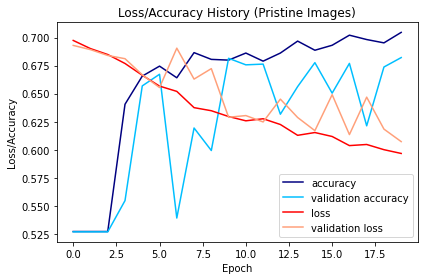

In [ ]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')

So what is validation set acctually used for? 

Neural networks are very complex - they can easily overfit to the data. We should always check if the model is able to perform on new unseen data, adn sto the training before performance on the new data starts to drop (signs of overfitting). We use validation set after every epoh to check if the model is overfitting or not.

![](https://miro.medium.com/v2/resize:fit:1400/1*JZbxrdzabrT33Yl-LrmShw.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/Screenshot-2020-02-06-at-11.09.13.png)

### 6. Presenting your results

To truly test the performance we need to show how well the model classifies 
unseen images (test set).

First let's apply the train model to the test data (evaluate the model). 
You can learn more about model.evaluate [here](https://keras.rstudio.com/reference/evaluate.keras.engine.training.Model.html).

In [ ]:
score = model.evaluate(X_test, y_test, verbose=True)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

97/97 [==============================] - 7s 74ms/step - loss: 0.5886 - accuracy: 0.7048
accuracy: 70.48%


Lets generate predictions and see ow many images were correctly classified.
You can read more about model. predicts [here](https://keras.rstudio.com/reference/predict.keras.engine.training.Model.html).

Since our model outputs a single number between 0-1 we need to pick a treshold that divides the two classes. Let's pick 0.5 for now.

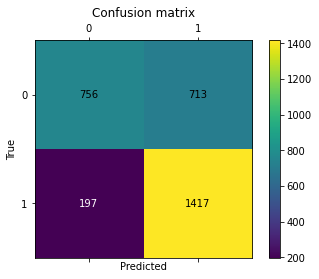

In [ ]:
# predict
prob = model.predict(X_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float') # regular CM
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis] # normalized CM


#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.0f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] < thresh else "black")
plt.show()

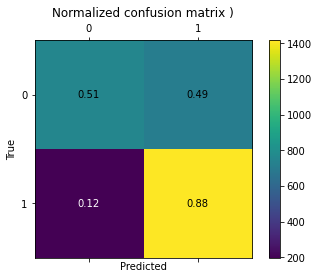

In [ ]:
#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Normalized confusion matrix )', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

Another common plot ir the Receiver Operating Characteristic (ROC) plot.

It shows the trade-off between TP and FP. 

A perfect cassifier has a curve that approaches top left corner, while a classifier that randomly predicts labels has ROC curve close to the diagonal.

Calculating the Area under the ROC curve (AUC) is a good indicator of performance (we aim to be close to AUC = 1).

Read more about the ROC curve and AUC [here](https://keras.rstudio.com/reference/metric_auc.html).

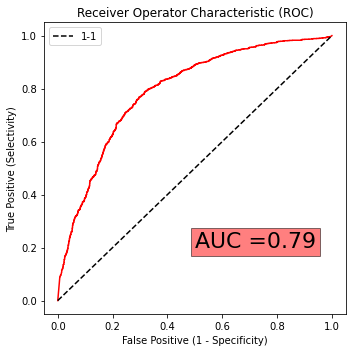

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prob, pos_label=1)
auc = roc_auc_score(y_test, prob)


figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
#Adding text inside a rectangular box by using the keyword 'bbox'
plt.text(0.5, 0.2, "AUC ="+"{0:.2f}".format(auc), fontsize = 22, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.tight_layout()

You should always report several different performance metrics next to accuracy.
For example precision or purity (recall) of your predictions.

What if your dataset includes two classes, but the data is vert imbalanced (one class represnts most of the dataset). You didn't train you model very well. How would accuracy, precision and recall look like in this case?

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 0.704833
Precision: 0.665258
Recall: 0.877943
F1 score: 0.756944


## FAQs

- **How do I interpret these results?** Observe how the loss for the validation set is higher than for the training set (and conversely, the accuracy for the validation set is lower than for the training set), suggesting that this model is suffering from [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Revisit [the original paper](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) and notice the strategies they employ to improve the validation accuracy. Observe [their Figure 2](https://www.sciencedirect.com/science/article/pii/S2213133720300445) for an example of what the results of a properly-trained network look like!


- **Can I improve the model by changing it?** We only trained for 20 epochs, which is many fewer than the published model. Go back to Section 4 ("Train the CNN to perform a classification task") and increase the number of epochs to 100 (or more!) and train again. Does your model perform better? Your results may look better/worse/different from the published results due to the stochastic nature of training. 


- **Can I try a different model?  I think the results could be improved.** Yes!  You can try adding layers, swapping out the max pooling, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate.  Experiment and see what model changes give the best results. You should be aware:  when you start training again, you pick up where your model left off.  If you want to "reset" your model to epoch 0 and random weights, you should run the cells to make and compile the model again.


- **I want to test my model on my training data!** No. You will convince yourself that your results are much better than they actually are.  Always keep your training, validation, and testing sets completely separate!


### Extensions/Exercises

- **Effect of noise?** Try re-training the network with "noisy" data (i.e., modify the `version` in Section 1 to "noisy" and download the associated data product). Do the results change? If so, how and why? What are the pros and cons of using noisy vs. pristine data to train a ML model? 



- **Effect of wavelength?** The DEEPMERGE HLSP includes mock galaxy images in 2 filters only (only HST data). If you train the network with this data (hint: this will require downloading it from the website, or modifying the download cells to point to the correct URL; and also modifying the shapes of the training, validation and test data, as well as the network inputs), how do the results change? 



- **How good are the model predictions** Use Keras' `model.predict` to generate model predictions for your test set (i.e., the set of data not used to train or validate the model). How do the predictions compare to the "true" answers for the test set? Does this comparison improve after increasing the number of epochs, changing the model structure and/or hyperparameters?



- **Early stopping?** The DeepMerge team employed "early stopping" to minimize overfitting. Try implementing it in the network here! The Keras library for [early stopping](https://keras.io/api/callbacks/early_stopping/) functions will be useful. For example, you can recompile the model, train for many more epochs, and include a `callback`, in `model.train` e.g.,

    `callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)`
    

*Don't forget, [the DeepMerge team provides code](https://github.com/deepskies/deepmerge-public) for building their production-level model and verifying its results, please check them out for more extensions and ideas!*


## About this Notebook
This notebook has been slightly modified by A. Ćiprijanović and is based on the notebook hoseted on the [Helo Universe website](https://archive.stsci.edu/hello-universe). Some modifications are also utilizing amazing explanations and images from a [tutorial by John Wu](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/tree/main/week-1).

**Author of the orignal notebook:** Claire Murray, Data Scientist, cmurray1@stsci.edu based on the code repository for the paper <a href="https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Data Scientist, mntampaka@stsci.edu.

**Updated On:** 2022-3-10

## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)



[Top of Page](#top)